In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Dota 2:  Meta Evolution as Captured by End-of-game Player Stats

## Executive Summary

Dota 2 is a multiplayer online battle arena (MOBA) game that has gained top tier popularity in E-sports. Ushered in by the success of its predecessor, Defense of the Ancients, it has grown to be a force in the gaming industry exhibited by a host of following and a historically high prize pool in the game's flagship annual tournament, `The International` (TI) . 

Perhaps the most appealing aspect of Dota 2 is teamwork. From the drafting stage to late-game clashes, teamwork surfaced as a unifying factor of all our investigations. Specifically, we have observed that intelligence-type support heroes held count majority on hero pick participation across all TIs. We also observed that the dependence of team strategies on players taking different roles or specializations in-game results in the distribution of end-of-game stats that resemble Poisson/rare--a consequence of the majority of support players giving way to a snowballing of one or two core heroes in a lineup.

Also, we built a predictive model that can predict match outcomes at ~94% accuracy. In prediction using in-game hero items, map vision and mobility items surfaced as the most important predictors. Aegis is also among the top predictor items which we attributed to success in team fights and, consequently, secured pushing. Intuitively, we observed that Kills, Deaths, and Assists are the most important stats to predict match outcomes at high accuracy.

While `Valve` certainly made efforts to refine and improve the game continuously, there is a limit to how much they can change. That limit is Dota 2's identity--as exhibited in the overall package of mechanics, graphics, and what others refer to as  "high barrier of entry."<sup><a href="https://www.joindota.com/en/news/78006-opinion-its-time-for-dota-2-to-lower-the-barrier-to-entry">[1]</a></sup> This is supported by the statistically insignificant differences in end-of-game stats from TI4 to TI8 as determine by Null Hypothesis Significant Testing. Like most E-sports games, `Valve` faces an everyday challenge of keeping Dota 2 relevant but authentic to what it was always known for, a big-brain team-strategy e-sport. Only time will tell what the outcome is to Dota 2's <i>a defense from being ancient</i> in the history of MOBA.


## I. Introduction

The E-Sports industry has changed significantly since the early age of the internet, changed marked by staggering growth in the last decade. In fact, the number of games released<sup><a href="https://www.statista.com/statistics/552623/number-games-released-steam/">[2]</a></sup> in Steam alone in 2018 and 2019 is twice as much as the combined games released a decade ago. One game that has reached a massive global audience is **Dota 2**.

Dota 2 has improved significantly since the release of its predecessor, **Defense of the Ancients (DOTA)**, in 2003. DOTA was initially a `mod` for the video game **Warcraft III: Reign of Chaos** and **The Frozen Throne**. It is a multiplayer online battle arena game wherein two opposing teams fight by defending respective central bases called `Ancients` and by destroying the opponent's base. Each team is composed of five (5) players who control individual characters called `heroes`. Throughout the years, DOTA has been a favorite in the MOBA gaming segment.

DOTA's growing popularity caught the attention of `Valve`, which led to a collaboration with DOTA's original creators, who eventually gave birth to Dota 2. Valve officially released Dota 2 in July 2013 as the first standalone installment of Defense of the Ancients.

Dota 2 kept the same gameplay mechanics as DOTA while enhancing outdated graphics and visual effects. These graphics, along with the game mechanics, are continuously updated through `patches`. The patches add new elements, change existing bugs, and generally keep the game "fresh." These patches allowed for flexibility in keeping the game relevant despite increasing competition in both computer and mobile MOBA games. What sets Dota 2 apart from its competitors, however, is `Valve`'s annual hosting of the prestigious yearly `The International` (TI).

The International is an annual E-Sports world championship tournament where the top professional teams who have passed the qualifier round go head to head against each other in claiming the `Aegis`, TI's championship trophy. The tournament is one of the largest in the E-Sports industry, with the highest recorded prize pool for a single event valued at $34 Million (2019).

## II. The Objectives

Dota 2 has undergone many game updates since the first The International (TI1). Currently, it is now in its 7.27c patch. These updates came mostly as responses to game bugs, game imbalance, and the more compelling objective of Valve to keep Dota 2 relevant amidst increasing competition in the Multiplayer Online Battle Arena (MOBA) category.

In the gaming community, updates imply changes in the meta--how the objectives in a game are achieved. In this report, we investigated how the Dota 2 meta evolved through the years using end-of-game data per match played in a TI. We focused our investigation specifically on The International 4 to 8 (TI4 to TI8) due to the availability of data in Steam's API.<sup><a href="https://steamcommunity.com/dev">[3]</a></sup>

The following questions direct our exploration:
	
1. How has the pick-ban strategy of professional teams evolved throughout the TIs observed?
2. What are the top predictors of match outcomes?
3. How has TI games meta evolved with the continuous patch updates from `Valve` as far as end-of-game statistics is concerned?

In [113]:
from IPython.display import Image 
# This is only for presentation
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## III. Data Collection, Description, and Processing

To accomplish the above objectives, our team scraped data from Steam using its API and performed the necessary exploratory data analayses. Our scraping resulted to two two main sets of data: (1) data for analysis, and (2) data for visualization. The collected data were saved in sqlite3 with `dota2.sqlite3` as the **main database**. The following tables are contained in the said database:

1. leagues and tournaments
2. heroes
3. items
4. matches details including picks, and bans

Presented below is our workflow diagram, overviews of the data displayed as `pandas` dataframes, and the necessary processing of 
of data prior to analyses.

*Steam API endpoints are shown in the Appendix.*

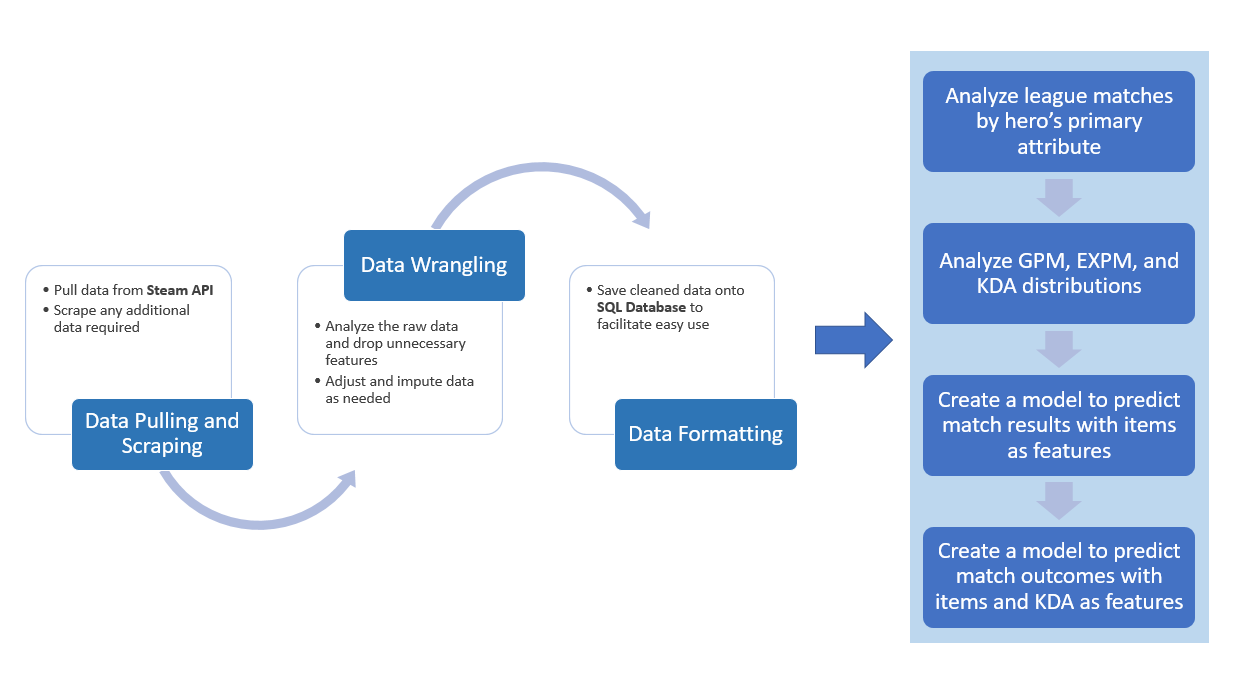

In [114]:
Image('workflow.png')

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import requests
from tqdm import tqdm

In [116]:
db_path = '/mnt/processed/private/msds2021/lt10/'
heroes_db = 'dota2_v1.db'
dota2db = 'dota2.sqlite3'
dota_heroes = 'dota_heroes.db'

In [117]:
hero_conn = sqlite3.connect(db_path + heroes_db)
# hero_conn = sqlite3.connect(heroes_db)
hero_conn.execute('SELECT * FROM dota_heroes')
df_heroes = pd.read_sql("""SELECT * FROM dota_heroes""", hero_conn)

In [118]:
# use to match the hero names from the viz data to Steam API data
hero_names = {
    'nevermore': 'Shadow Fiend',
    'vengefulspirit': 'Vengeful Spirit',
    'windrunner': 'Windranger',
    'zuus': 'Zeus',
    'nercolyte': 'Necrophos',
    'rattletrap': 'Clockwerk',
    'queenofpain': 'Queen of Pain',
    'skeleton king': 'Wraith King',
    'wisp': 'Io',
    'life stealer': 'Lifestealer',
    'doom bringer': 'Doom',
    'obsidian destroyer': 'Outworld Devourer',
    'treant': 'Treant Protector',
    'centaur': 'Centaur Warrunner',
    'magnataur': 'Magnus',
    'shredder': 'Timbersaw',
    'abyssal underlord': 'Underlord',
    'furion': "Nature's Prophet"
}

#### Tables contained in the `dota2.sqlite3` database

In [119]:
conn = sqlite3.connect(db_path + dota2db)
conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

[('heroes',),
 ('items',),
 ('leagues',),
 ('matches',),
 ('match_players',),
 ('picks_bans',),
 ('match_details',)]

In [120]:
leagues_df = pd.read_sql_query('SELECT * FROM leagues', con=conn)
leagues_df.head()

,name,league_id,description,tournament_url,itemdef
0,#DOTA_Item_The_International_2012,65001,#DOTA_Item_Desc_League_TheInternational,http://www.dota2.com/tournaments/international...,15072
1,#DOTA_Item_The_International_East_Qualifiers,65004,#DOTA_Item_Desc_The_International_East_Qualifiers,http://www.dota2.com/tournaments/international...,15157
2,#DOTA_Item_The_International_West_Qualifiers,65005,#DOTA_Item_Desc_Copy_of_The_International_East...,http://www.dota2.com/tournaments/international...,15158
3,#DOTA_Item_The_International_TP,65006,#DOTA_Item_Desc_The_International_TP,http://www.dota2.com/international/announcement/,15406
4,#DOTA_Item_The_International_2014,600,#DOTA_Item_Desc_Copy_of_The_International,http://www.dota2.com/international/overview/,15768


In [121]:
matches_df = pd.read_sql_query('SELECT * FROM matches', con=conn)
matches_df.head()

,series_id,series_type,match_id,match_seq_num,start_time,lobby_type,radiant_team_id,dire_team_id,league_id
0,0,0,37633163,36588728,2012-09-03 05:06:14,1,5,36,65001
1,0,0,37629117,36584196,2012-09-03 04:11:02,1,36,5,65001
2,0,0,37626434,36580456,2012-09-03 03:33:27,1,5,36,65001
3,0,0,37623177,36578120,2012-09-03 02:49:34,1,36,5,65001
4,0,0,37613366,36570849,2012-09-03 01:20:12,1,15,5,65001


In [122]:
m_details_df = pd.read_sql_query('SELECT * FROM match_details', con=conn)
m_details_df.head()

,radiant_win,duration,pre_game_duration,start_time,match_id,match_seq_num,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,...,radiant_team_id,radiant_name,radiant_logo,radiant_team_complete,dire_team_id,dire_name,dire_logo,dire_team_complete,radiant_captain,dire_captain
0,1,3434,0,1346648774,37633163,36588728,1846,0,63,48,...,5.0,INVICTUS GAMING,9.754798e+17,1.0,36.0,Natus Vincere,7.706133e+17,1.0,NaN,NaN
1,0,2310,0,1346645462,37629117,36584196,1796,1972,63,63,...,36.0,Natus Vincere,7.706133e+17,1.0,5.0,INVICTUS GAMING,9.754798e+17,1.0,NaN,NaN
2,0,1140,0,1346643207,37626434,36580456,1592,1974,14,63,...,5.0,INVICTUS GAMING,9.754798e+17,1.0,36.0,Natus Vincere,7.706133e+17,1.0,NaN,NaN
3,0,1700,0,1346640574,37623177,36578120,1540,1974,3,63,...,36.0,Natus Vincere,7.706133e+17,1.0,5.0,INVICTUS GAMING,9.754798e+17,1.0,NaN,NaN
4,0,2686,0,1346635212,37613366,36570849,1796,1958,55,63,...,15.0,PSG.LGD,9.270561e+17,1.0,5.0,INVICTUS GAMING,9.754798e+17,1.0,NaN,NaN


In [123]:
picks_bans_df = pd.read_sql_query('SELECT * FROM picks_bans', con=conn)
picks_bans_df.head()

,is_pick,hero_id,team,order,match_id
0,0,51,0,0,207148444
1,0,88,1,1,207148444
2,0,65,0,2,207148444
3,0,55,1,3,207148444
4,1,54,0,4,207148444


In [124]:
heroes, cnt = np.unique(picks_bans_df.hero_id, return_counts=True)

In [125]:
heroes_df = pd.read_sql_query('SELECT * FROM heroes', con=conn)
df_heroes['Hero Name'] = df_heroes['Hero Name'].str.lower()
df_heroes['Hero Name'] = df_heroes['Hero Name'].str.replace('-', '')
df_heroes['Hero Name'] = df_heroes['Hero Name'].str.replace('nercolyte', 'necrolyte')
df_heroes.head()

,level_0,index,Hero Type,Hero Name,Hero Picture,Hero Link
0,0,0,Strength,abaddon,https://gamepedia.cursecdn.com/dota2_gamepedia...,https://dota2.gamepedia.com/Abaddon
1,1,1,Strength,alchemist,https://gamepedia.cursecdn.com/dota2_gamepedia...,https://dota2.gamepedia.com/Alchemist
2,2,2,Strength,axe,https://gamepedia.cursecdn.com/dota2_gamepedia...,https://dota2.gamepedia.com/Axe
3,3,3,Strength,beastmaster,https://gamepedia.cursecdn.com/dota2_gamepedia...,https://dota2.gamepedia.com/Beastmaster
4,4,4,Strength,brewmaster,https://gamepedia.cursecdn.com/dota2_gamepedia...,https://dota2.gamepedia.com/Brewmaster


In [126]:
heroes_deets_df = pd.merge(heroes_df, df_heroes, left_on='name', 
                           right_on='Hero Name', how='left').drop_duplicates()

In [127]:
heroes_deets_df = heroes_deets_df.drop('index', axis=1)

In [128]:
main_stats = [
    heroes_deets_df[heroes_deets_df.hero_id == h_id]['Hero Type'].values[0]
    for h_id in picks_bans_df.hero_id
]

In [129]:
picks_bans_df['main_stat'] = main_stats

## IV. Exploratory Data Analysis

Our analyses to understand the changes in Dota 2 meta according to the previously stated objectives are answered in the following exploratory data analysis sections:

    A. `The International` Hero Selection: Analyzed by Hero's Primary Attribute

    B. Predicting Match Outcomes and the Top Outcome Predictors

    C. End-of-game Stats' Statistical Significance to TI Evolution



### A. `The International` Hero Selection: Analyzed by Hero's Primary Attribute

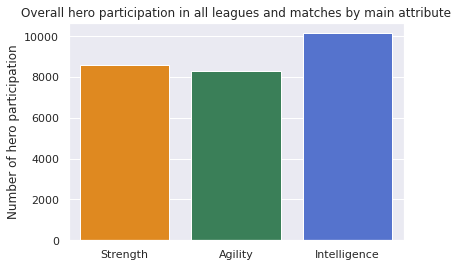

In [130]:
sns.countplot(picks_bans_df.main_stat, palette={ 'Intelligence': 'royalblue',
    'Strength': 'darkorange','Agility': 'seagreen'})
plt.title("Overall hero participation in all leagues and matches by main attribute")
plt.ylabel("Number of hero participation")
plt.xlabel("");

#### Section Insights

* We can observe the for TI4 to TI8, Intelligence-type heroes had the highest overall participation in picks and bans. This observation is supported by the fact that Intelligence-typed heroes bring an abundance of crowd-control and burst damage skills that are crucial in team fights.
* Also, the usual five-man team is composed of two support heroes, an offlaner, a mid-carry hero, and a safelane carry hero. Supports are usually intelligence heroes which already tips the hero counts to this primary attribute. In addition, there are quite a few mid-carry heroes which drives the count even higher. Some of these int-type mid favorites are `Tinker`, `Invoker`, and `Queen of Pain`.

In [131]:
matches_by_league = matches_df.groupby('league_id').match_id.unique()
matches_by_league[:5]

league_id
600     [683689782, 683782650, 683949082, 684017244, 6...
2733    [1697618202, 1697676707, 1697737102, 169781823...
4664    [2569415435, 2569470828, 2569531910, 256961090...
4768    [2460470597, 2460368035, 2460284429, 246013142...
5401    [3372622939, 3372676225, 3372726385, 337226970...
Name: match_id, dtype: object

In [132]:
picks_df = picks_bans_df[picks_bans_df.is_pick == 1]
bans_df = picks_bans_df[picks_bans_df.is_pick == 0]

In [133]:
# official TIs league ids
official_TI = [600, 2733, 4664, 5401, 9870]

### Hero Pick-Ban Participations

We further looked into hero participation by looking into picks and bans as discussed below. We sorted the data set into different TIs in order to observe any changes on the counts for each primary attribute. Observations were made for both Picks and Bans, a stage in the beginning of a match where teams take turns in picking and banning heroes.  

#### Hero pick participation by main attribute per TI

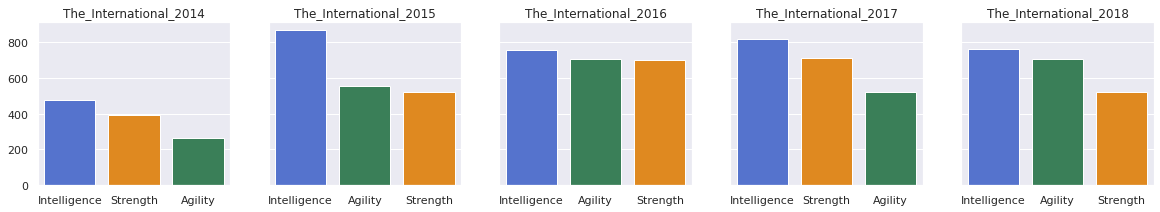

In [134]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(20, 3))
palette = {
    'Intelligence': 'royalblue',
    'Strength': 'darkorange',
    'Agility': 'seagreen'
}
for league, ax in zip(official_TI, ax):
    data = picks_df[picks_df.match_id.isin(matches_by_league[league])]
    sns.countplot(x='main_stat', data=data, 
                  order=data.main_stat.value_counts().index, 
                  palette=palette, ax=ax)
    tourney = leagues_df[leagues_df.league_id == league].name.str.replace('#DOTA_Item_', '').values[0]
    ax.set_title(tourney)
    ax.set_xlabel('')
    ax.set_ylabel('')

#### Section Insights
* We can observe from the plots above that TI4 had relatively fewer games brought by the smaller tournamet format at that time.
* Although the plots are still consistent in showing int-type heroes to comprise the majority of picks, we can observe an increase in agi-type picks during TI6 and TI8. These increases are attributed to the popularity of in type scouts, `Riki` and `Bounty Hunter`. `Monkey King` also became part in of the Dota 2 meta in TI8 as one of these flexible agi-type scouts. 

#### Hero ban participation by main attribute per TI

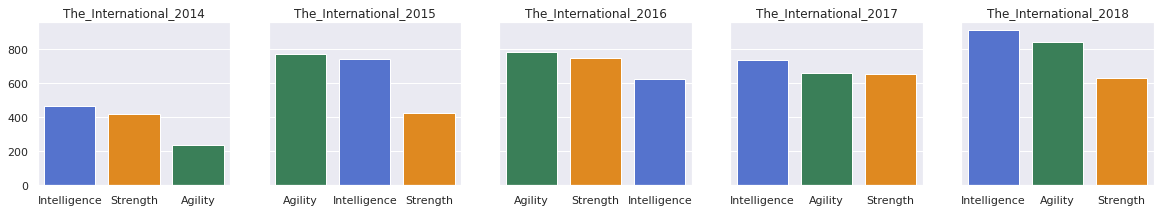

In [135]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(20, 3))
palette = {
    'Intelligence': 'royalblue',
    'Strength': 'darkorange',
    'Agility': 'seagreen'
}
for league, ax in zip(official_TI, ax):
    data = bans_df[bans_df.match_id.isin(matches_by_league[league])]
    sns.countplot(x='main_stat', data=data, 
                  order=data.main_stat.value_counts().index, 
                  palette=palette, ax=ax)
    tourney = leagues_df[leagues_df.league_id == league].name.str.replace('#DOTA_Item_', '').values[0]
    ax.set_title(tourney)
    ax.set_xlabel('')
    ax.set_ylabel('')

#### Section Insights

* We can observe that for TI5 and TI6, agility heroes are banned the most. These can be explained by tendency of these heroes to dominate the game and secure wins provided that they get good support in the games early stages.
* Also, we can observe that in TI7 and TI8, int-heroes get band the most. TIs where teams with "all star" player line-ups like `Team Liquid` can snowball with mid-cores such as `Miracle`'s `Invoker`.

In [136]:
heroes_names = [
    heroes_deets_df[heroes_deets_df.hero_id == h_id].name.values[0]
    for h_id in picks_bans_df.hero_id
]

In [137]:
picks_bans_df['hero_names'] = heroes_names

In [138]:
picks_df = picks_bans_df[picks_bans_df.is_pick == 1]
bans_df = picks_bans_df[picks_bans_df.is_pick == 0]

### A Look Into First Picks
In the pick-ban stage, teams already battle it out by trying to pick the heroes which best fits their chosen strategy without revealing that strategy to their opponents. It is also crucial that teams are able to read their opponent's plan based on the manner of how heroes are being picked or banned. In this early mind game in the match, it would be worth looking into how teams choose their first picks.

#### First pick heroes' main attribute per TI

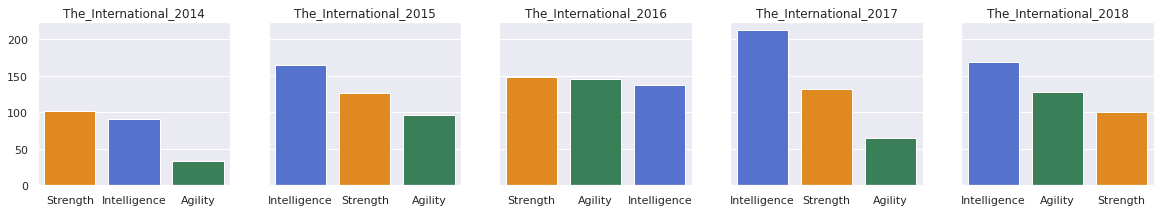

In [139]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(20, 3))
palette = {
    'Intelligence': 'royalblue',
    'Strength': 'darkorange',
    'Agility': 'seagreen'
}
for league, ax in zip(official_TI, ax):
    data = picks_df[picks_df.match_id.isin(matches_by_league[league])]
    data = data[data.order.isin([6, 7])]
    data = data[data.main_stat.isin(data.main_stat.value_counts()[:15].index)]
    sns.countplot(x='main_stat', data=data, orient='h',
                  order=data.main_stat.value_counts().index, 
                  palette=palette, ax=ax)
    tourney = leagues_df[leagues_df.league_id == league].name.str.replace('#DOTA_Item_', '').values[0]
    ax.set_title(tourney)
    ax.set_xlabel('')
    ax.set_ylabel('')

#### Section Insights

* From this initial countplot, it is difficult to observe any strategy in the first pick apart from the usual observation in favoring int-type as support heroes. Teams usually pick non-core (support) heroes first to save their core hereoes from being countered. 
* Also, we can observe strength-type heroes being pcked early on in the game due to their resilience in oppenent counter-picking.

In [140]:
types = {'Intelligence':'royalblue', 'Strength':'darkorange', 'Agility':'seagreen'}
dataframe = (df_heroes[['Hero Name', 'Hero Type']].drop_duplicates().set_index('Hero Name'))
dataframe['Hero Type'] = dataframe['Hero Type'].map(types)
palette = dataframe.to_dict()['Hero Type']

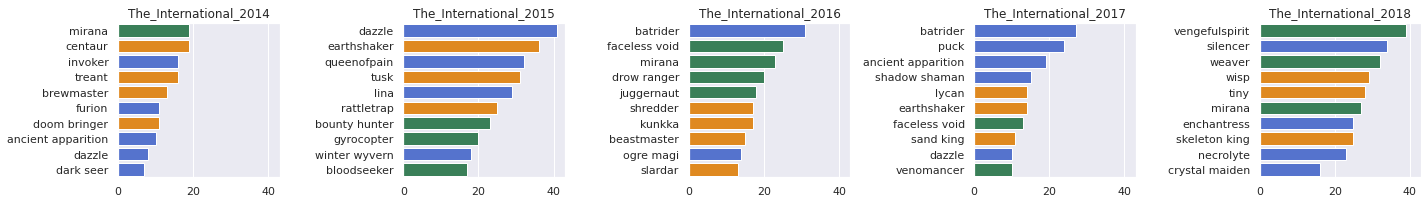

In [141]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=True, figsize=(20, 3))
lists = []
for league, ax in zip(official_TI, ax):
    data = picks_df[picks_df.match_id.isin(matches_by_league[league])]
    data = data[data.order.isin([6, 7])]
    data = data[data.hero_names.isin(data.hero_names.value_counts()[:10].index)]
    ha = ['right', 'center', 'left']
    xlabels = data.hero_names
    sns.countplot(y='hero_names', data=data, orient='h',
                  order=data.hero_names.value_counts().index, ax=ax, palette=palette)
    tourney = leagues_df[leagues_df.league_id == league].name.str.replace('#DOTA_Item_', '').values[0]
    ax.set_title(tourney)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.tight_layout()

#### Section Insights
* We can observe that most first picked heroes are those with crowd control and attribute-increasing (buff) skills that can fit in most type of team strategies.

* The heroes which appear as top picks, in addition, have the best trade-offs between team fight relevance and in concealing the overall strategy a team plans to use.

### B. Predicting Match Outcomes and the Top Outcome Predictors

One may ask, what wins a Dota 2 game? Considering the many factors that affects a games outcome, our team performed an analysis on the top predictors of TI outcomes using end-game data obtained from Steam's API. Specifically, we used a `Gradient Boosting Classifier` model to determine outcomes. We also explored using the following features and obtained the corresponding accuracies.

**1. Items Only: ~83% Accuracy**<br>
**2. All available end-game data: ~94 Accuracy**

Presented below is our analysis and details regarding the features used.

In [142]:
match_players = pd.read_sql_query('SELECT * FROM match_players', con=conn)
match_players.head()

,account_id,player_slot,hero_id,item_0,item_1,item_2,item_3,item_4,item_5,backpack_0,...,deaths,assists,leaver_status,last_hits,denies,gold_per_min,xp_per_min,level,match_id,additional_units
0,82327674,0,90,214,46,61,42,24,102,0,...,2,21,0,123,0,241,281,17,37633163,NaN
1,88585077,1,46,147,0,46,1,50,141,0,...,6,17,0,254,16,453,493,23,37633163,NaN
2,90137663,2,89,196,147,63,46,114,123,0,...,5,15,0,418,7,526,556,24,37633163,NaN
3,90045009,3,55,96,119,214,79,90,46,0,...,2,17,0,279,3,406,531,24,37633163,NaN
4,88553213,4,29,180,36,1,110,30,37,0,...,1,24,0,103,0,271,365,20,37633163,NaN


In [143]:
dota_items = pd.read_sql_query('SELECT * from items', con=conn)
dota_items.head()

,name,cost,secret_shop,side_shop,recipe,item_id
0,blink,2250,0,0,0,1
1,blades of attack,450,0,0,0,2
2,broadsword,1000,0,0,0,3
3,chainmail,550,0,0,0,4
4,claymore,1400,0,0,0,5


In [144]:
full_matches = pd.merge(m_details_df[['match_id', 'radiant_win']], match_players, on='match_id')
full_matches = pd.merge(matches_df[['match_id', 'league_id']], full_matches, on='match_id')
full_matches = pd.merge(leagues_df[['league_id', 'name']], full_matches, on='league_id')
full_matches = pd.merge(full_matches, heroes_df, on='hero_id').rename(columns={'name_y':'hero_name'})

In [145]:
full_matches['radiant_win'] = full_matches['radiant_win'].transform(lambda x: bool(x==1))
full_matches['items'] = list(full_matches[['item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5']].values)
full_matches['radiant'] = full_matches.apply(lambda x: bool(x['player_slot'] <=100), axis=1)
full_matches['win'] = ~((full_matches['radiant']) ^ (full_matches['radiant_win']))
full_matches.head()

,league_id,name_x,match_id,radiant_win,account_id,player_slot,hero_id,item_0,item_1,item_2,...,last_hits,denies,gold_per_min,xp_per_min,level,additional_units,hero_name,items,radiant,win
0,65001,#DOTA_Item_The_International_2012,37633163,True,82327674,0,90,214,46,61,...,123,0,241,281,17,NaN,keeper of the light,"[214, 46, 61, 42, 24, 102]",True,True
1,65001,#DOTA_Item_The_International_2012,37578738,True,87278757,128,90,43,214,36,...,61,2,201,198,11,NaN,keeper of the light,"[43, 214, 36, 73, 37, 23]",False,False
2,65001,#DOTA_Item_The_International_2012,37086655,True,85805514,131,90,102,37,11,...,69,1,239,231,10,NaN,keeper of the light,"[102, 37, 11, 214, 16, 0]",False,False
3,65001,#DOTA_Item_The_International_2012,37062303,True,82630959,130,90,214,34,46,...,93,2,184,174,11,NaN,keeper of the light,"[214, 34, 46, 92, 30, 42]",False,False
4,65001,#DOTA_Item_The_International_2012,36255449,True,85805514,2,90,102,11,61,...,83,0,339,284,12,NaN,keeper of the light,"[102, 11, 61, 214, 73, 61]",True,True


#### 1. Features Used: Items Only
Prior to building our predictive model we aggregated team data per match. Additionally, we performed one-hot encoding for categorical features of the data. In these section, features used are only the items used by each team per match. See below codes and dataframe for the the result of this preprocessing.

In [146]:
items_cols = ['item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5', 
              'backpack_0', 'backpack_1', 'backpack_2', 'item_neutral']

In [147]:
combined_df = full_matches[['match_id', 'radiant', 'win']]

item_df = pd.get_dummies(full_matches[items_cols].stack()).sum(level=0)
item_df.columns = ['item_' + str(col) for col in item_df.columns]
new_df = pd.concat([combined_df, item_df], axis=1)
new_df = new_df.groupby(['match_id', 'radiant']).sum()
new_df = new_df.drop('item_0', axis=1)
new_df.win = new_df.win / 5.0
new_df.head()

win  item_1  item_2  item_3  item_4  item_5  item_6  item_7  \
match_id radiant                                                                
36030092 False    0.0       1       0       0       0       0       0       0   
         True     1.0       2       0       0       0       0       0       0   
36035663 False    1.0       0       0       0       0       0       0       0   
         True     0.0       0       0       0       0       0       0       0   
36036525 False    1.0       0       0       0       0       0       0       0   

                  item_8  item_9  ...  item_257  item_258  item_259  item_260  \
match_id radiant                  ...                                           
36030092 False         0       1  ...         0         0         0         0   
         True          0       0  ...         0         0         0         0   
36035663 False         0       0  ...         0         0         0         0   
         True          0       0  ...         0         0         0         0   
36036525 False         0       0  ...         0         0         0         0   

                  item_262  item_263  item_265  item_266  item_267  item_1029  
match_id radiant                                                               
36030092 False           0         0         0         0         0          0  
         True            0         0         0         0         0          0  
36035663 False           0         0         0         0         0          0  
         True            0         0         0         0         0          0  
36036525 False           0         0         0         0         0          0  

[5 rows x 192 columns]

In [148]:
from sklearn.model_selection import train_test_split

X = new_df[new_df.columns[1:]]
y = new_df[['win']].values.flatten().astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [149]:
from sklearn.ensemble import GradientBoostingClassifier

gbr = GradientBoostingClassifier(max_depth=4, learning_rate=.1, n_estimators=200, random_state=143)
gbr.fit(X_train, y_train)

print('train score: ', gbr.score(X_train, y_train))
print('test score:', gbr.score(X_test, y_test))

train score:  0.9645852749301025
test score: 0.8156424581005587


In [150]:
new_df.columns[1:][np.argsort(gbr.feature_importances_)[::-1]]

Index(['item_30', 'item_117', 'item_29', 'item_42', 'item_21', 'item_40',
       'item_218', 'item_90', 'item_36', 'item_38',
       ...
       'item_184', 'item_161', 'item_122', 'item_115', 'item_99', 'item_97',
       'item_91', 'item_85', 'item_84', 'item_120'],
      dtype='object', length=191)

In [151]:
dota_items[dota_items.item_id.isin([30, 117, 29, 40, 42])]

,name,cost,secret_shop,side_shop,recipe,item_id
38,boots,500,0,0,0,29
39,gem,900,0,0,0,30
50,dust,80,0,0,0,40
52,ward observer,0,0,0,0,42
154,aegis,0,0,0,0,117


#### Section Insights
Along with the success of building a predictive model in knowing match outcomes, the following insights surfaced:
* Top outcome predictors are the items shown in the dataframe above. We can observe that most of these items (`observer wards`, `dust`, `gem`) relate to map awareness, map vision, and team fights. 
* Intuitively, you can't win games without `boots`, an item which improves mobility that is useful in all aspects of the game--from team fights down to the farming in the laning stage.
* At the late game, acquiring an `Aegis of the Immortal` usually signifies team fight victories that often leads to successful push into the enemy base.

#### 2. Features used: Items and End-of-game Player Stats

In [152]:
stats_cols = ['kills', 'deaths', 'assists', 'last_hits', 'denies']

In [153]:
combined_df = full_matches[['match_id', 'radiant', 'win'] + stats_cols]

item_df = pd.get_dummies(full_matches[items_cols].stack()).sum(level=0)
item_df.columns = ['item_' + str(col) for col in item_df.columns]
new_df = pd.concat([combined_df, item_df], axis=1)
new_df = new_df.groupby(['match_id', 'radiant']).sum()
new_df = new_df.drop('item_0', axis=1)
new_df.win = new_df.win / 5.0
new_df.head()

win  kills  deaths  assists  last_hits  denies  item_1  \
match_id radiant                                                           
36030092 False    0.0     16      29       36        825      50       1   
         True     1.0     28      16       65        896      26       2   
36035663 False    1.0     15       4       20        262      57       0   
         True     0.0      4      15        5        203      24       0   
36036525 False    1.0     31      34       73        478      59       0   

                  item_2  item_3  item_4  ...  item_257  item_258  item_259  \
match_id radiant                          ...                                 
36030092 False         0       0       0  ...         0         0         0   
         True          0       0       0  ...         0         0         0   
36035663 False         0       0       0  ...         0         0         0   
         True          0       0       0  ...         0         0         0   
36036525 False         0       0       0  ...         0         0         0   

                  item_260  item_262  item_263  item_265  item_266  item_267  \
match_id radiant                                                               
36030092 False           0         0         0         0         0         0   
         True            0         0         0         0         0         0   
36035663 False           0         0         0         0         0         0   
         True            0         0         0         0         0         0   
36036525 False           0         0         0         0         0         0   

                  item_1029  
match_id radiant             
36030092 False            0  
         True             0  
36035663 False            0  
         True             0  
36036525 False            0  

[5 rows x 197 columns]

In [154]:
from sklearn.model_selection import train_test_split

X = new_df[new_df.columns[1:]]
y = new_df[['win']].values.flatten().astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [155]:
from sklearn.ensemble import GradientBoostingClassifier

gbr = GradientBoostingClassifier(max_depth=4, learning_rate=.1, n_estimators=200, random_state=143)
gbr.fit(X_train, y_train)

print('train score: ', gbr.score(X_train, y_train))
print('test score:', gbr.score(X_test, y_test))

train score:  0.9995340167753961
test score: 0.9553072625698324


In [156]:
new_df.columns[1:][np.argsort(gbr.feature_importances_)[::-1]]

Index(['kills', 'deaths', 'item_30', 'assists', 'last_hits', 'item_117',
       'denies', 'item_139', 'item_48', 'item_90',
       ...
       'item_120', 'item_122', 'item_125', 'item_140', 'item_262', 'item_146',
       'item_28', 'item_157', 'item_26', 'item_1029'],
      dtype='object', length=196)

In [157]:
dota_items[dota_items.item_id.isin([30, 117, 48, 139]) ]

,name,cost,secret_shop,side_shop,recipe,item_id
39,gem,900,0,0,0,30
63,travel boots,2500,0,0,0,48
154,aegis,0,0,0,0,117
193,butterfly,5275,0,0,0,139


#### Section Insights
* While pushing and destroying enemy buildings eventaully lead a team to breaking an opponent's `Ancient`, it is through `Kills` that teams are able to push effectively, turning the odds to their favor. Our predictive model supports this, putting `Kills` on the **top rank** as predictor of match outcomes.
* Additionally, we can see late-game items such as `travel boots` and `butterfly` to be deterministic of match outcomes. `Travel boots` allows flexibility in split pushing, which increases map presence. Also, `butterfly` signals that safelane-carry agility heroes are successful in their roles of farming up for the late-game eventually securing wins for the team.

### C. End-of-game Stats' Statistical Significance to TI Evolution

In order to detemine how TI meta has changed from TI4 and TI8, we also looked into the end-of-game stats of each player and the distributions of these stats. In addition, we performed Null Hyptohesis Significance Testing to determine if the differences in distributions resulting from Dota 2 updates are statistcally significant. The details are as follows.

In [158]:
conn = "sqlite:////mnt/processed/private/msds2021/lt10/dota2.sqlite3"
sql = "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;"
hero_id = pd.read_sql("SELECT * from heroes;", conn)
match_details = pd.read_sql("SELECT * FROM match_details;", conn)
match_players = pd.read_sql("SELECT * FROM match_players;", conn)
ti_ids = {
    "TI4":600,
    "TI5":2733,
    "TI6":4664,
    "TI7":5401,
    "TI8":9870
}

In [159]:
ti4_ids = match_details.loc[match_details.leagueid==ti_ids.get('TI4'), 'match_id']
ti5_ids = match_details.loc[match_details.leagueid==ti_ids.get('TI5'), 'match_id']
ti6_ids = match_details.loc[match_details.leagueid==ti_ids.get('TI6'), 'match_id']
ti7_ids = match_details.loc[match_details.leagueid==ti_ids.get('TI7'), 'match_id']
ti8_ids = match_details.loc[match_details.leagueid==ti_ids.get('TI8'), 'match_id']

In [160]:
ti_match_ids = {
    4: ti4_ids,
    5: ti5_ids,
    6: ti6_ids,
    7: ti7_ids,
    8: ti8_ids
}
for i in range(4, 9):
    match_players.loc[match_players.match_id.isin(ti_match_ids.get(i)),
                      'TI'] = i
    match_details.loc[match_details.match_id.isin(ti_match_ids.get(i)),
                      'TI'] = i

#### 1. The Poisson Distribution and Rare IMBA Endgame Stats

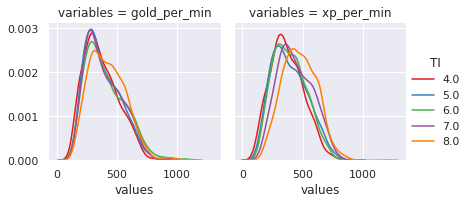

In [161]:
ge_cols = ['gold_per_min', 'xp_per_min', 'TI']
ge = match_players[ge_cols]
ge_melt = ge.melt(['TI'], var_name='variables', value_name='values')

sns.set()
g = sns.FacetGrid(ge_melt, col="variables", hue="TI", palette="Set1")
g = (g.map(sns.distplot, "values", hist=False))
g.add_legend()
plt.show()

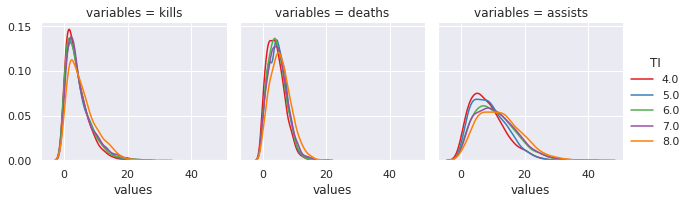

In [162]:
kda_cols = ['kills', 'deaths', 'assists', 'TI']
kda = match_players[kda_cols]
kda_melt = kda.melt(['TI'], var_name='variables', value_name='values')

sns.set()
k = sns.FacetGrid(kda_melt, col="variables", hue="TI", palette="Set1")
k = (k.map(sns.distplot, "values", hist=False))
k.add_legend()
plt.show()

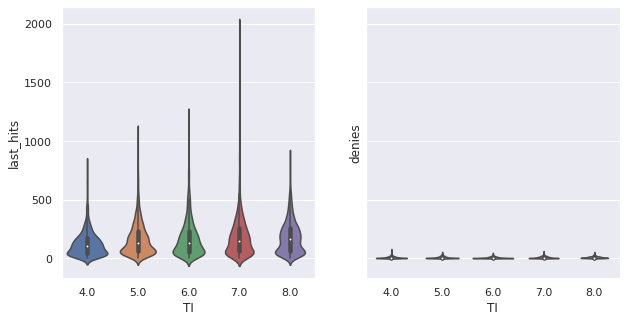

In [163]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
cols = ['last_hits', 'denies']
for index, col in enumerate(cols):
    _ = sns.violinplot(x='TI', y=col, data=match_players, ax=ax[index])
plt.show()

#### Section Insights
* Most endgame stats, specifically gpm, xpm, kills, deaths, and assists **resemble a Poisson distribution** from visual inspection. We can observe that the distributions are generally skewed to the right. Thus, we can consider high values for these end-of-game stats as **rare events**. This is primarily explained by the fact that in TI, a team can "tap-out" of a game by calling  "good game, well played".

* Additionally, Poisson distribution of stats are also **due to players taking clearly defined roles in a team strategy** where most roles function as support heroes (characterized by lower stats to favor snowballing of the fewer in proportion carry-heroes (usually 1 or 2 per team). Therefore high--also known in the Philippine gaming linggo as **"IMBA"--stats are significantly outnumbered by support hero stats** in our data set since we included the stats of all five player roles per team per match.

* **Talent Trees Patch.** Apart from the rare IMBA stats, we observed a **slight shift to the right of the TI 7 and 8 stats distributions**. One of the major updates that sets apart the TI 7 and 8 patch from the rest is the addition of Hero Talent Trees. Talent trees are additional buffs in skills and stats which are hero specific. For the majority support heroes, it is common to see **talents such as bonus gold or experience per minute** which results to the mentioned rightward shift in the mean of the distribution of XPM and GPM. <sup><a href="https://www.dota2.com/700/gameplay/">[4]</a></sup>

* Valve also intentionally **increased the experience gain from the laning stages** (e.g. from last hits and neutral camps) to attract focus in leveling up of heroes in-game. Again, this supports the rightward shift earlier mentioned. A possible explanation to this is **the regard for Dota 2 as one of those games with a high barrier of entry**, characterized by a patience-demanding laning and farming stage for game newbies.

#### 2. Testing TI8's End-game Stats Difference with Null Hypothesis Significance Testing

While eyeballing the end-game stats distribution (KDE) plots of the different TIs may give an idea how they compare with each other, the above plots do not tell the statistical significance of the differences or similarities.

One of the differences shown from the above plots is how TI8 had a slightly more spread out distribution of end-game experience and gold per minute results. To verify if the observed difference is indeed statistically significant, we conducted a Null Hypothesis Significance Testing (NHST) on the mean differences of end-game stats available from the Steam API.

In the NHST below, we calculated for the probability of observing mean differences in end-game stats that is equal or greater than the actual mean differences observed from the pairwise comparison of TI8 with the other TIs.

To do so we defined our hypothesis as follows:

**Hypothesis (Null):** All of the TI's end-game per player stats, specifically  experience per minute(xpm), gold per minute gpm), kills (K), deaths (D), assists (A), last-hits, and denies, are identically distributed with TI8's end-game per player stats.

**Test statistic:** Mean difference of each end-of-game stat.

#### Defining the functions used

The following are the functions used to perform the NHST. Definitions of each function are indicated in the contained docstrings

In [13]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[0:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

#### Null Hypothesis Significance Testing (NHST)
Permutation replicates of the test statistic (mean difference) was done 10,000 times for a reliable simulation of the actual data.

The resulting mean differences and the corresponding probability (expressed in p-value) are shown in the dataframe that follows.

*Note:*<br>
* *test statistic is suffixed in the columns with "_mean_diff"* <br>
* *P-value is suffixed in the columns with "_pvalue"* 

In [15]:
ti_list = [4.0, 5.0, 6.0, 7.0] # TIs to compare TI8 with

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays. Test statistic used"""

    # The difference of means of data_1, data_2 (our test statistic)
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

nhst_df = pd.DataFrame(index=[f'TI_{int(ti)}' for ti in ti_list])

var_list = ['xp_per_min', 'gold_per_min', 'kills', 'deaths', 'assists',
            'last_hits', 'denies']
col_list = ['xpm', 'gpm', 'K', 'D', 'A', 'last_hit', 'deny']
i = 0
for var in tqdm(var_list):
    p_list = []
    mean_diff = []
    for ti in ti_list:
        data_1 = match_players.loc[match_players.TI==8.0, var]
        data_2 = match_players.loc[match_players.TI==ti, var]

        # Compute difference of means
        empirical_diff_means = diff_of_means(data_1, data_2)

        # Draw 10,000 permutation replicates
        perm_replicates = draw_perm_reps(data_1, data_2,
                                         diff_of_means, size=10_000)

        # Compute p-value: p
        if empirical_diff_means < 0:
            p = np.sum(perm_replicates <= empirical_diff_means) / len(perm_replicates)
        else:
            p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)
        p_list.append('{:.4f}'.format(p))
        mean_diff.append('{:.2f}'.format(empirical_diff_means))
    nhst_df[col_list[i] +'_mean_diff'] = mean_diff
    nhst_df[col_list[i] +'_pvalue'] = p_list
    i += 1

nhst_df

100%|██████████| 7/7 [00:38<00:00,  5.54s/it]


,xpm_mean_diff,xpm_pvalue,gpm_mean_diff,gpm_pvalue,K_mean_diff,K_pvalue,D_mean_diff,D_pvalue,A_mean_diff,A_pvalue,last_hit_mean_diff,last_hit_pvalue,deny_mean_diff,deny_pvalue
TI_4,102.91,0.0000,53.56,0.0000,1.55,0.0000,1.56,0.0000,3.82,0.0000,55.73,0.0000,1.45,0.0000
TI_5,80.07,0.0000,38.90,0.0000,1.01,0.0000,0.96,0.0000,3.10,0.0000,17.62,0.0001,1.12,0.0000
TI_6,79.51,0.0000,16.05,0.0009,1.14,0.0000,1.09,0.0000,1.41,0.0000,9.36,0.0185,2.74,0.0000
TI_7,35.76,0.0000,28.24,0.0000,0.83,0.0000,0.83,0.0000,1.09,0.0000,-0.62,0.4419,0.62,0.0078


#### Section Insights

* From the resulting in the dataframe above, we can observe that under the null hypothesis ONLY the the mean difference in "last_hit" stats between TI7 and TI8 is shown to be statistically significant at a 95% confidence interval. Statistically, the mean differences in end-game stats from TI4 to TI8 are generally insignificant given by the results. This **TI7 last_hit pvalue of 0.4419** may be attributed to **IMBA outliers** such as that of the 1970 last hits in a game by `Resolut1on` in their game against `IG.V`. <sup><a href="https://www.youtube.com/watch?v=h1JVcX9DSaQ">[5]</a></sup>


* The insignificance of differences in end-of-game stats of TI8 shows that meta changes due to Dota 2 `patches` cannot easily be captured by end-of-game statistics. It shows that **Dota 2 has not change drastically** since it's 2011 release as far as end-of-game statistics is concerned.

## VI. Conclusion and Recommendations

End-of-game stats made it possible for us to predict match outcomes and surface the top predictors to these outcomes. We also observed from our data the trends in hero selection according to the primary attribute. However, we recommend that a thorough analysis be done on a possible time-series data set with more specific information about what happened throughout a match with the corresponding timestamp. An investigation in this direction allows one to see in-game stats progression and team strategies and play style.

## References 


[1]  2018. Opinion — it’s time for Dota 2 to lower the barrier to entry. [Blog] Available at: <https://www.joindota.com/en/news/78006-opinion-its-time-for-dota-2-to-lower-the-barrier-to-entry> [Accessed August 2020].

[2] Statista. 2020. Number Of Games Released On Steam 2019 | Statista. [online] Available at: <https://www.statista.com/statistics/552623/number-games-released-steam/> [Accessed 1 August 2020].

[3] Steamcommunity.com. 2020. Steam Community :: Steam Web API Documentation. [online] Available at: <https://steamcommunity.com/dev> [Accessed 1 August 2020].

[4] Dota2.com. 2020. Dota 2 - 7.00 - New Gameplay. [online] Available at: <https://www.dota2.com/700/gameplay> [Accessed 1 August 2020].

[5] 2020. [online] Available at: <https://www.youtube.com/watch?v=h1JVcX9DSaQ> [Accessed 1 August 2020].

## Appendix

Our team created a module `dota.py` in collecting the data from Steam API.

The Steam API endpoints used are the following:

    BASE_API_URL = 'http://api.steampowered.com/'
    LEAGUES = 'IDOTA2Match_205790/GetLeagueListing/v1/'
    MATCH_HISTORY = 'IDOTA2Match_570/GetMatchHistory/v1/'
    MATCH_DETAILS = 'IDOTA2Match_570/GetMatchDetails/v1/'
    HEROES_DETAILS = 'IEconDOTA2_570/GetHeroes/v1/'
    ITEMS_DETAILS = 'IEconDOTA2_570/GetGameItems/v1/'
    
    
Our team scraped hero and item images from:

    heroes: https://dota2.gamepedia.com/Heroes
    items: https://dota2.gamepedia.com/Items

## End